##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Understanding recurrent neural networks 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/intro_to_RNN"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/models/blob/master/samples/core/tutorials/keras/intro_to_RNN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/models/blob/master/samples/core/tutorials/keras/intro_to_RNN.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This tutorial gives a brief introduction of recurrent neural networks (RNN).  The code example in this tutorial is adapted from Chapter 6, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff).  

We'll use [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train a simple RNN model in TensorFlow. 

## Introduction

A major characteristics for traditional neural networks is that they process each input independently, with no states kept in between inputs. With such models, a sequence input, such as an entire movie review on IMDB, needs to be transformed into a single data point, and processed in one go.

In contrast, recurrent neural networks (RNN) process sequence input by iterating through the elements in the sequence, and maintain a state for all the data it has seen so far.  Taking IMDB movie review as an example, RNN processes each review word by word.  When processing a word, the RNN network "remembers" the state of all the previous words in this review.  The state of the RNN is reset when processing another independent input, such as another review.

In [2]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

1.10.1


## A recurrent layer in Keras

In [3]:
from tensorflow.keras.layers import SimpleRNN

Like all recurrent layers in Keras, SimpleRNN can be run in two different modes: it can return either the full sequences of successive outputs for each timestep (a 3D tensor of shape (batch_size, timesteps, output_features)), or it can return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). These two modes are controlled by the return_sequences constructor argument.

Let's take a look at an example that uses SimpleRNN and returns only the output at the last timestep:

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


The following example returns the full state sequence.

In [5]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, you have to get all intermediate layers to return full sequences:

In [6]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [7]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
17465344/17464789 [==============================] - 11s 1us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an Embedding layer and a SimpleRNN layer:

In [8]:
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 24s 1ms/step - loss: 0.6916 - acc: 0.5272 - val_loss: 0.6703 - val_acc: 0.5798
Epoch 2/10
20000/20000 [==============================] - 24s 1ms/step - loss: 0.6449 - acc: 0.6162 - val_loss: 0.6021 - val_acc: 0.6758
Epoch 3/10
20000/20000 [==============================] - 23s 1ms/step - loss: 0.5808 - acc: 0.6925 - val_loss: 0.6939 - val_acc: 0.6008
Epoch 4/10
20000/20000 [==============================] - 23s 1ms/step - loss: 0.5313 - acc: 0.7325 - val_loss: 0.7792 - val_acc: 0.5810
Epoch 5/10
20000/20000 [==============================] - 23s 1ms/step - loss: 0.4931 - acc: 0.7600 - val_loss: 0.4893 - val_acc: 0.7684
Epoch 6/10
20000/20000 [==============================] - 23s 1ms/step - loss: 0.4641 - acc: 0.7834 - val_loss: 0.5582 - val_acc: 0.7144
Epoch 7/10
20000/20000 [==============================] - 23s 1ms/step - loss: 0.4276 - acc: 0.8087 - val_loss: 0.5189 - val_acc:

Let's display the training and validation loss and accuracy:

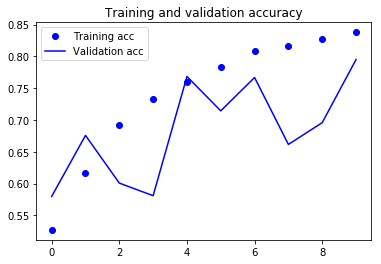

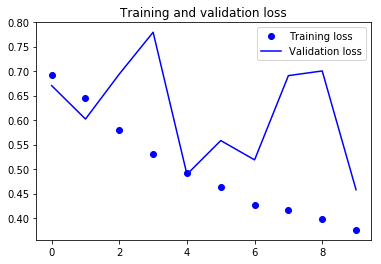

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As a reminder, in [basic text classification tutorial](https://www.tensorflow.org/tutorials/keras/basic_text_classification) , our fairly naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is that our inputs only consider the first 500 words rather the full sequences -- hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that SimpleRNN isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some more advanced layers. 

## A concrete LSTM example in Keras

Although SimpleRNN should retain the information about inputs seen many timesteps before, in practice, such long-term dependency is impossible to learn because of the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).  Long Short-Term Memory (LSTM) algorithm was developed to overcome this problem. Please see [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) for an introduction to LSTM.

The example below is a network with LSTM layer, similar to the one with SimpleRNN that we just presented. For simplicity, we only specify the output dimensionality of the LSTM layer, and leave every other argument (there are lots) to the Keras defaults. 

In [11]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 93s 5ms/step - loss: 0.6796 - acc: 0.5633 - val_loss: 0.6642 - val_acc: 0.5808
Epoch 2/10
20000/20000 [==============================] - 88s 4ms/step - loss: 0.5943 - acc: 0.6855 - val_loss: 0.5269 - val_acc: 0.7522
Epoch 3/10
20000/20000 [==============================] - 90s 5ms/step - loss: 0.4889 - acc: 0.7682 - val_loss: 0.4070 - val_acc: 0.8182
Epoch 4/10
20000/20000 [==============================] - 90s 4ms/step - loss: 0.4134 - acc: 0.8184 - val_loss: 0.3626 - val_acc: 0.8464
Epoch 5/10
20000/20000 [==============================] - 90s 4ms/step - loss: 0.3527 - acc: 0.8532 - val_loss: 0.4175 - val_acc: 0.8082
Epoch 6/10
20000/20000 [==============================] - 87s 4ms/step - loss: 0.2997 - acc: 0.8750 - val_loss: 0.4665 - val_acc: 0.7966
Epoch 7/10
20000/20000 [==============================] - 88s 4ms/step - loss: 0.2656 - acc: 0.8944 - val_loss: 0.3143 - val_acc:

Let's display the training and validation loss and accuracy:

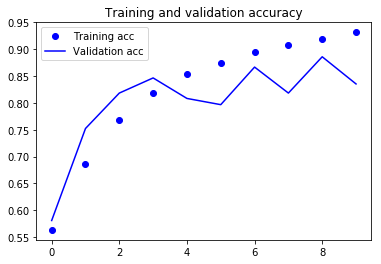

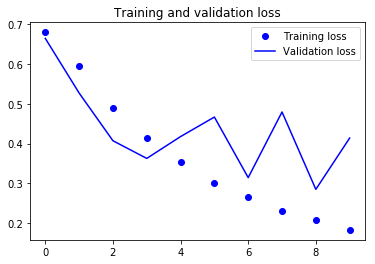

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()